### 複数受信機による位置推定
本研究ではビーコン信号を用いた複数受信機による位置推定を行う。  
実験環境は本学の施設内で行い、屋内の正確な位置推定を目標に実験及び分析を行う。  
本実験で使用しているビーコン数は7つ、受信機は4つである。

In [1]:
# 必要なライブラリの読み込み
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.family'] = 'IPAPGothic' #全体のフォントを設定
plt.rcParams["figure.figsize"] = [20, 12] # グラフのサイズを指定
plt.rcParams['font.size'] = 20 #フォントサイズを設定 default : 12
plt.rcParams['xtick.labelsize'] = 15 # 横軸のフォントサイズ
plt.rcParams['ytick.labelsize'] = 15 # 縦軸のフォントサイズ

#### 取得データの前処理を行う

In [2]:
# パターン7の各実験データを取得
df7_1 = pd.read_csv("./取得データセット/受信機1/nkmr1_pattern7.csv")
df7_2 = pd.read_csv("./取得データセット/受信機2/nkmr2_pattern7.csv")
df7_3 = pd.read_csv("./取得データセット/受信機3/nkmr3_pattern7.csv")
df7_4 = pd.read_csv("./取得データセット/受信機4/nkmr4_pattern7.csv")
#それぞれのカラム名の指定
df7_1.columns = ["UUIDs","Major","Minor","Accuracy","Proximity","TxPower","RSSI","device_name","timestamp"]
df7_2.columns = ["UUIDs","Major","Minor","Accuracy","Proximity","TxPower","RSSI","device_name","timestamp"]
df7_3.columns = ["UUIDs","Major","Minor","Accuracy","Proximity","TxPower","RSSI","device_name","timestamp"]
df7_4.columns = ["UUIDs","Major","Minor","Accuracy","Proximity","TxPower","RSSI","device_name","timestamp"]
#受信機4のデータを前処理
df7_4["RSSI"]= df7_4["RSSI"].replace("\\N","")
df7_4=df7_4.drop(60637)
df7_4["RSSI"] = df7_4["RSSI"].astype(int)
#データの結合
df7 = df7_1.append(df7_2).append(df7_3).append(df7_4)
df7 = df7[df7["UUIDs"] != "80000000aaaa41441111110000000000"]
df = df7

#### 取得データを見る。

In [3]:
df.head()

,UUIDs,Major,Minor,Accuracy,Proximity,TxPower,RSSI,device_name,timestamp
1,40000000aaaa41441111110000000000,2,35,1.53738,near,-78,-87,rasp1,2017/10/23 15:42:42
2,30000000aaaa41441111110000000000,2,34,1.39725,near,-78,-85,rasp1,2017/10/23 15:42:42
3,60000000aaaa41441111110000000000,2,39,1.39725,near,-78,-85,rasp1,2017/10/23 15:42:42
4,10000000aaaa41441111110000000000,2,38,1.46564,near,-78,-86,rasp1,2017/10/23 15:42:42
5,30000000aaaa41441111110000000000,2,34,1.39725,near,-78,-85,rasp1,2017/10/23 15:42:42


#### 各ラベルの情報：  
UUIDs,Major,Minor : 発信機の特定に使われる  
Accuracy : 推定距離のばらつきを示す  
Proximity : 1M地点でビーコンが発する信号の強さ  
RSSI : 電波強度  
device_name : 受信機名  
timestamp : 受信時の時間を記録

### 実験パターン7のデータを用いての位置推定
実験パターン7では複数受信機と複数発信器を元にデータを取得した。  
実験環境は本学屋内施設の１部屋を使用している。  
受信機は部屋内の４隅に設置してデータを取得し、発信機は以下の実験イメージ図に示すとおりに設置した。  
<img src="./RSSI取得実験図/実験7/パターン7.png" alt="パターン7">
<img src="./RSSI取得実験図/実験7/IMG_2975.JPG" alt="パターン7-1">
<img src="./RSSI取得実験図/実験7/IMG_9954.JPG" alt="パターン7-2">

In [4]:
#　オブジェクト型の目的変数を数値情報に変換
import sklearn.preprocessing as sp

# UUIDsを変換
le = sp.LabelEncoder()
df["locate"] = le.fit_transform(df[df.columns[0]]) + 1
# device_nameを変換
le = sp.LabelEncoder()
df["device"] = le.fit_transform(df[df.columns[7]]) + 1
# timestampを変換
le = sp.LabelEncoder()
df["date_label"] = le.fit_transform(df[df.columns[8]]) + 1

In [5]:
df.head()

,UUIDs,Major,Minor,Accuracy,Proximity,TxPower,RSSI,device_name,timestamp,locate,device,date_label
1,40000000aaaa41441111110000000000,2,35,1.53738,near,-78,-87,rasp1,2017/10/23 15:42:42,4,3,1
2,30000000aaaa41441111110000000000,2,34,1.39725,near,-78,-85,rasp1,2017/10/23 15:42:42,3,3,1
3,60000000aaaa41441111110000000000,2,39,1.39725,near,-78,-85,rasp1,2017/10/23 15:42:42,6,3,1
4,10000000aaaa41441111110000000000,2,38,1.46564,near,-78,-86,rasp1,2017/10/23 15:42:42,1,3,1
5,30000000aaaa41441111110000000000,2,34,1.39725,near,-78,-85,rasp1,2017/10/23 15:42:42,3,3,1


ここでのdate_labelは実際には時刻は合っていないが、本ケースでは時刻は合っているものとして位置推定を行う。

In [6]:
# 学習用のデータセットを用意
train_x = np.array(df[["RSSI","device","date_label"]])
train_y = np.array(df["locate"])

# データの標準化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
train_ss = ss.fit_transform(train_x)

# データの正規化
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
train_mm = mm.fit_transform(train_x)

/Users/e135726/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/e135726/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
train_mm

array([[ 0.34375   ,  0.66666667,  0.        ],
       [ 0.40625   ,  0.66666667,  0.        ],
       [ 0.40625   ,  0.66666667,  0.        ],
       ..., 
       [ 0.375     ,  0.33333333,  0.99897751],
       [ 0.40625   ,  0.33333333,  0.99897751],
       [ 0.5625    ,  0.33333333,  0.99897751]])

In [8]:
train_ss

array([[-0.36128614,  0.42714366, -1.70498372],
       [ 0.08929157,  0.42714366, -1.70498372],
       [ 0.08929157,  0.42714366, -1.70498372],
       ..., 
       [-0.13599728, -0.4600189 ,  1.74114283],
       [ 0.08929157, -0.4600189 ,  1.74114283],
       [ 1.21573587, -0.4600189 ,  1.74114283]])

#### RSSI、受信機、取得時間を特徴量として学習を行う

In [9]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# KFold検定を行うインスタンスを作成
kf = KFold(n_splits=3,shuffle=True)

# 検定を行うデータを定義(正規化、標準化なし)
X = np.array(df[["RSSI","device","date_label"]])
y = train_y

print("正規化、標準化なし:")

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # オブジェクトを作成し学習
    mod = xgb.XGBClassifier()
    clf = mod.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print("精度 : %s" % score)
    
# 検定を行うデータを定義(標準化)
X = train_mm
y = train_y

print("標準化:")

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # オブジェクトを作成し学習
    mod = xgb.XGBClassifier()
    clf = mod.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print("精度 : %s" % score)
      
# 検定を行うデータを定義(正規化)
X = train_ss
y = train_y

print("正規化:")

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # オブジェクトを作成し学習
    mod = xgb.XGBClassifier()
    clf = mod.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print("精度 : %s" % score)

正規化、標準化なし:
精度 : 0.58251613231
精度 : 0.581195061227
精度 : 0.584461776886
精度 : 0.578059500521
精度 : 0.585223952643
標準化:
精度 : 0.580864793456
精度 : 0.588892840811
精度 : 0.578161123955
精度 : 0.58258174335
精度 : 0.583648789411
正規化:
精度 : 0.587139881104
精度 : 0.585209084904
精度 : 0.582505525774
精度 : 0.580346027794
精度 : 0.583902847997


精度は約6割くらいになった。

###  反射波と入射派を分別して場所判定を行う。  
まずは地点毎にクラスタリングを行い、入射派と反射派の判定を行う。

In [12]:
# KMeansライブラリをインポート
from sklearn.cluster import KMeans

In [10]:
# 地点7つに対して発信機ごとに種類分け
df_1 = df[df['UUIDs']  == "10000000aaaa41441111110000000000"]
df_2 = df[df['UUIDs']  == "20000000aaaa41441111110000000000"]
df_3 = df[df['UUIDs']  == "30000000aaaa41441111110000000000"]
df_4 = df[df['UUIDs']  == "40000000aaaa41441111110000000000"]
df_5 = df[df['UUIDs']  == "50000000aaaa41441111110000000000"]
df_6 = df[df['UUIDs']  == "60000000aaaa41441111110000000000"]
df_7 = df[df['UUIDs']  == "70000000aaaa41441111110000000000"]

/Users/e135726/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/e135726/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


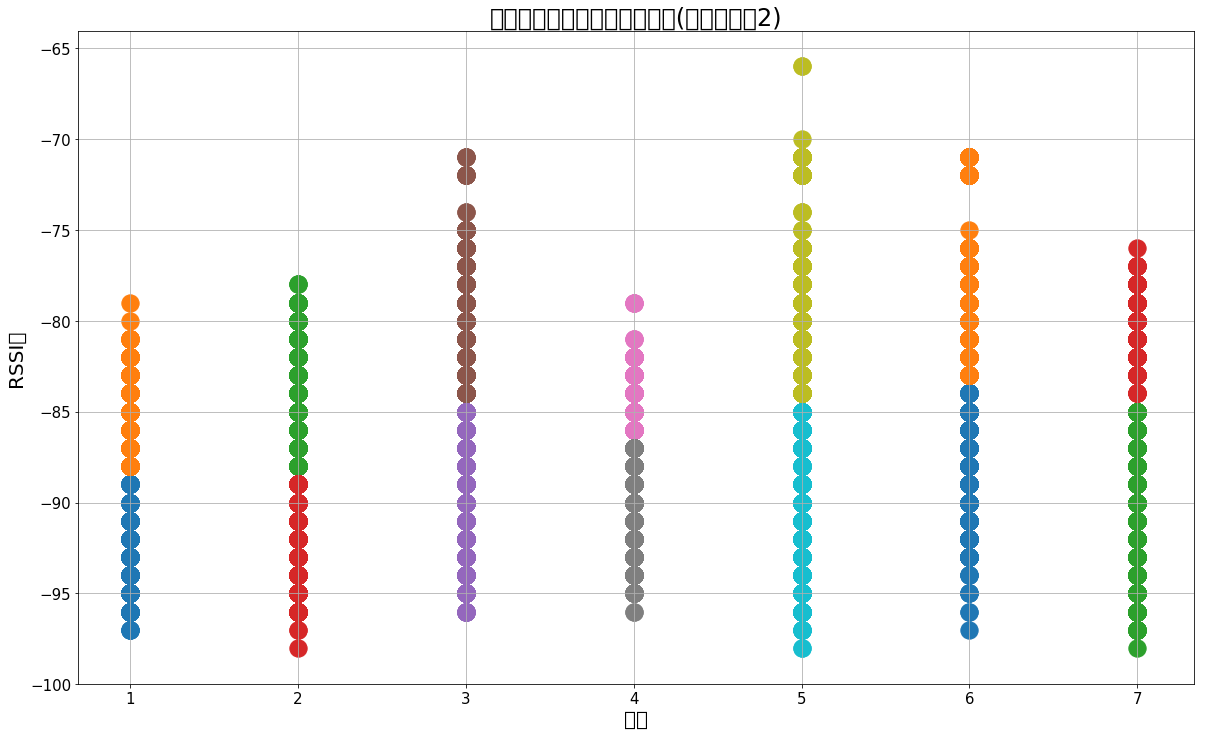

In [15]:
# クラスタ数
N_CLUSTERS = 2

# RSSIとlocate情報を使用してクラスタリング
pred_1 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_1[["RSSI","locate"]])
df_1.loc[:,("pred")] = pred_1
for i in range(2):
    labels1 = df_1[pred_1 == i]
    plt.scatter(labels1["locate"],labels1["RSSI"],s=300)

pred_2 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_2[["RSSI","locate"]])
df_2.loc[:,("pred")] = pred_2
for i in range(2):
    labels2 = df_2[pred_2 == i]
    plt.scatter(labels2["locate"],labels2["RSSI"],s=300)
    
pred_3 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_3[["RSSI","locate"]])
df_3.loc[:,("pred")] = pred_3
for i in range(2):
    labels3 = df_3[pred_3 == i]
    plt.scatter(labels3["locate"],labels3["RSSI"],s=300)

pred_4 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_4[["RSSI","locate"]])
df_4.loc[:,("pred")] = pred_4
for i in range(2):
    labels4 = df_4[pred_4 == i]
    plt.scatter(labels4["locate"],labels4["RSSI"],s=300)
    
pred_5 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_5[["RSSI","locate"]])
df_5.loc[:,("pred")] = pred_5
for i in range(2):
    labels5 = df_5[pred_5 == i]
    plt.scatter(labels5["locate"],labels5["RSSI"],s=300)

pred_6 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_6[["RSSI","locate"]])
df_6.loc[:,("pred")] = pred_6
for i in range(2):
    labels6 = df_6[pred_6 == i]
    plt.scatter(labels6["locate"],labels6["RSSI"],s=300)
    
pred_7 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_7[["RSSI","locate"]])
df_7.loc[:,("pred")] = pred_7
for i in range(2):
    labels7 = df_7[pred_7 == i]
    plt.scatter(labels7["locate"],labels7["RSSI"],s=300)
    
# データフレームの結合
df_cluster = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7],ignore_index=True)

plt.title("全地点のクラスタリング結果(クラスタ数2)")
plt.xlabel("地点")
plt.ylabel("RSSI値")
plt.grid(True)
plt.show()

In [16]:
df_cluster

,UUIDs,Major,Minor,Accuracy,Proximity,TxPower,RSSI,device_name,timestamp,locate,device,date_label,pred
0,10000000aaaa41441111110000000000,2,38,1.46564,near,-78,-86,rasp1,2017/10/23 15:42:42,1,3,1,1
1,10000000aaaa41441111110000000000,2,38,1.86121,near,-78,-91,rasp1,2017/10/23 15:42:42,1,3,1,0
2,10000000aaaa41441111110000000000,2,38,2.04787,near,-78,-93,rasp1,2017/10/23 15:42:42,1,3,1,0
3,10000000aaaa41441111110000000000,2,38,1.95231,near,-78,-92,rasp1,2017/10/23 15:42:43,1,3,2,0
4,10000000aaaa41441111110000000000,2,38,1.39725,near,-78,-85,rasp1,2017/10/23 15:42:44,1,3,3,1
5,10000000aaaa41441111110000000000,2,38,1.95231,near,-78,-92,rasp1,2017/10/23 15:42:45,1,3,4,0
6,10000000aaaa41441111110000000000,2,38,2.04787,near,-78,-93,rasp1,2017/10/23 15:42:46,1,3,5,0
7,10000000aaaa41441111110000000000,2,38,2.04787,near,-78,-93,rasp1,2017/10/23 15:42:46,1,3,5,0
8,10000000aaaa41441111110000000000,2,38,1.46564,near,-78,-86,rasp1,2017/10/23 15:42:46,1,3,5,1
9,10000000aaaa41441111110000000000,2,38,2.04787,near,-78,-93,rasp1,2017/10/23 15:42:46,1,3,5,0


In [17]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# KFold検定を行うインスタンスを作成
kf = KFold(n_splits=3,shuffle=True)

# 検定を行うデータを定義(正規化、標準化なし)
X = np.array(df_cluster[["RSSI","device","date_label","pred"]])
y = np.array(df_cluster["locate"])

print("正規化、標準化なし:")

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # オブジェクトを作成し学習
    mod = xgb.XGBClassifier()
    clf = mod.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print("精度 : %s" % score)

正規化、標準化なし:
精度 : 0.719220157615
精度 : 0.720953629463
精度 : 0.716090972836


制度は約7割の値になった。やはりRSSI値をクラスタ分割することは地点予測に対して有効であると思われる。  
本ケースではクラスタリングを受信機を考慮せずにRSSI値のみで行なっているため受信機を考慮して学習を行ってみる。

/Users/e135726/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/e135726/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


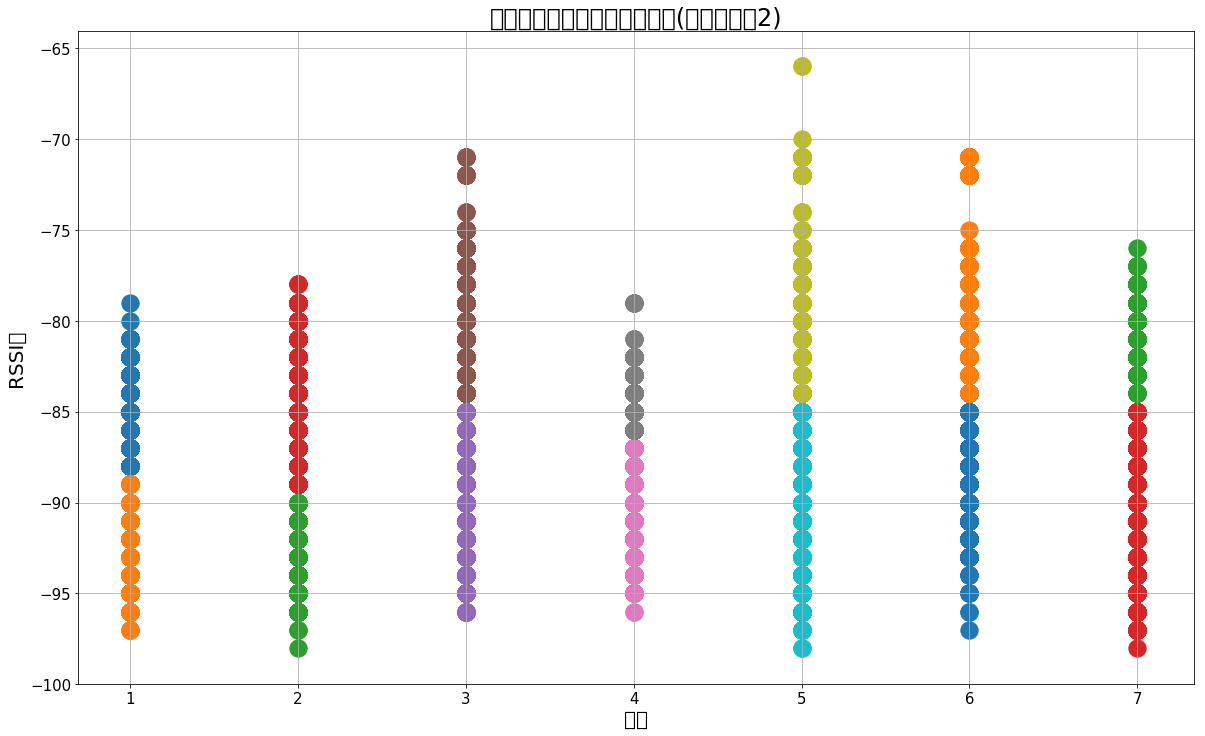

In [18]:
# クラスタ数
N_CLUSTERS = 2

# RSSIとlocate情報を使用してクラスタリング
pred_1 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_1[["RSSI","locate","device"]])
df_1.loc[:,("pred")] = pred_1
for i in range(2):
    labels1 = df_1[pred_1 == i]
    plt.scatter(labels1["locate"],labels1["RSSI"],s=300)

pred_2 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_2[["RSSI","locate","device"]])
df_2.loc[:,("pred")] = pred_2
for i in range(2):
    labels2 = df_2[pred_2 == i]
    plt.scatter(labels2["locate"],labels2["RSSI"],s=300)
    
pred_3 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_3[["RSSI","locate","device"]])
df_3.loc[:,("pred")] = pred_3
for i in range(2):
    labels3 = df_3[pred_3 == i]
    plt.scatter(labels3["locate"],labels3["RSSI"],s=300)

pred_4 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_4[["RSSI","locate","device"]])
df_4.loc[:,("pred")] = pred_4
for i in range(2):
    labels4 = df_4[pred_4 == i]
    plt.scatter(labels4["locate"],labels4["RSSI"],s=300)
    
pred_5 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_5[["RSSI","locate","device"]])
df_5.loc[:,("pred")] = pred_5
for i in range(2):
    labels5 = df_5[pred_5 == i]
    plt.scatter(labels5["locate"],labels5["RSSI"],s=300)

pred_6 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_6[["RSSI","locate","device"]])
df_6.loc[:,("pred")] = pred_6
for i in range(2):
    labels6 = df_6[pred_6 == i]
    plt.scatter(labels6["locate"],labels6["RSSI"],s=300)
    
pred_7 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_7[["RSSI","locate","device"]])
df_7.loc[:,("pred")] = pred_7
for i in range(2):
    labels7 = df_7[pred_7 == i]
    plt.scatter(labels7["locate"],labels7["RSSI"],s=300)
    
# データフレームの結合
df_cluster = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7],ignore_index=True)

plt.title("全地点のクラスタリング結果(クラスタ数2)")
plt.xlabel("地点")
plt.ylabel("RSSI値")
plt.grid(True)
plt.show()

クラスタリングをし直したので再度地点予測を行う。

In [19]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# KFold検定を行うインスタンスを作成
kf = KFold(n_splits=3,shuffle=True)

# 検定を行うデータを定義(正規化、標準化なし)
X = np.array(df_cluster[["RSSI","device","date_label","pred"]])
y = np.array(df_cluster["locate"])

print("正規化、標準化なし:")

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # オブジェクトを作成し学習
    mod = xgb.XGBClassifier()
    clf = mod.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print("精度 : %s" % score)

正規化、標準化なし:
精度 : 0.75584958005
精度 : 0.747446724185
精度 : 0.75105941892


精度が少し上がった。しかし、この方法だと発信機から遠い受信機と近い受信機など受信機ごとにうまくクラスタを形成できていないのでうまく学習に利用できていない。そのため、クラスタリングの結果を受信機毎に用意することで解決することにする。